# Compare Model to Algorithmic Approaches

## Imports

In [1]:
from datetime import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 300
import torch
from torch.nn.parallel import DataParallel as DP, DistributedDataParallel as DDP

from tomopy.prep.stripe import remove_stripe_fw, remove_stripe_based_sorting, remove_stripe_based_interpolation
from larix.methods.misc import INPAINT_EUCL_WEIGHTED, INPAINT_NDF, INPAINT_NM

from network.patch_visualizer import PatchVisualizer
from network.models import MaskedGAN
from network.models.generators import PatchUNet
from network.models.discriminators import PatchDiscriminator
from utils.data_io import loadTiff
from utils.tomography import reconstruct

# Number of threads for OpenMP. If too high, may cause error
%env OMP_NUM_THREADS=16

CuPy is not installed
CuPy is not installed
env: OMP_NUM_THREADS=16


## Functions
TomoPy edits sinograms in-place, so we must copy the input to avoid changing it.<br>
TomoPy also expects 3D volumes to have shape `(angles, det Y, det X)` so we must swap axes 0 and 1.

In [3]:
def fourier_wavelet(sino_volume, level=None, wname='db5', sigma=2, pad=True, ncore=None):
    inpt = sino_volume.copy().swapaxes(0, 1)
    output = remove_stripe_fw(inpt, level, wname, sigma, pad, ncore=ncore)
    return output.swapaxes(0, 1)


def remove_stripes_based_sorting(sino_volume, size=21, dim=1, ncore=None):
    inpt = sino_volume.copy().swapaxes(0, 1)
    output = remove_stripe_based_sorting(inpt, size, dim, ncore=ncore)
    return output.swapaxes(0, 1)

def remove_stripe_based_interpolation(sino_volume, snr=3, size=31, drop_ratio=0.1, norm=True, ncore=None):
    inpt = sino_volume.copy().swapaxes(0, 1)
    output = remove_stripe_based_interpolation(inpt, snr, size, drop_ratio, norm, ncore=ncore)
    return output.swapaxes(0, 1)

def remove_stripes_larix(sino_volume, mask, mode='NDF'):
    if mode == 'NDF':
        func = INPAINT_NDF
        kwargs = dict(regularisation_parameter=5000, edge_parameter=0, iterationsNumb=5000,
                      time_marching_parameter=0.000075, penalty_type=1)
    elif mode == 'EUCL':
        func = INPAINT_EUCL_WEIGHTED
        kwargs = dict(iterationsNumb=3, windowsize_half=2, method_type='random')
    elif mode == 'NM':
        func = INPAINT_NM
        kwargs = dict(SW_increment=2, iterationsNumb=150)
    else:
        raise ValueError(f"Mode {mode} not recognized.")
    inpainted = np.empty_like(sino_volume)
    for s in range(sino_volume.shape[0]):
        inpainted[s] = func(sino_volume[s], mask[s], **kwargs)
    return inpainted

In [4]:
def root_mean_squared_error(data1, data2, axis=None):
    return np.sqrt(np.mean(np.square(data1 - data2), axis=axis))

In [5]:
def load_model(path, device=None):
    # Load model state dict from disk
    checkpoint = torch.load(path, map_location=device)
    # Initialize Generator and Discriminator
    gen = DP(PatchUNet())
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc = DP(PatchDiscriminator())
    disc.load_state_dict(checkpoint['disc_state_dict'])
    # Initialize Model
    model = MaskedGAN(gen, disc, mode='test', device=device)
    return model

## Setup

### Parameters

In [6]:
i12 = Path('/dls/i12/data/2022/nt33730-1/processing/NoStripesNet')
data_dir = i12/'data'/'wider_stripes'
model_file = i12/'pretrained_models'/'five_sample'/'4x4'/'val'/'five_sample_4x4_100.tar'
mask_file = i12/'stripe_masks.npz'

if torch.cuda.is_available():
    d = torch.device('cuda')
else:
    d = torch.device('cpu')

rng = np.random.default_rng()
sample_no = 0
print(f"Sample No.: {sample_no}")

Sample No.: 0


### Load Model & Visualizer

In [7]:
model = load_model(model_file, device=d)
v = PatchVisualizer(data_dir, model, sample_no=sample_no, mask_file=mask_file)

RuntimeError: Error(s) in loading state_dict for DataParallel:
	size mismatch for module.up5.0.weight: copying a param with shape torch.Size([1024, 256, 4, 4]) from checkpoint, the shape in current model is torch.Size([1024, 256, 5, 4]).
	size mismatch for module.up8.0.weight: copying a param with shape torch.Size([128, 1, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 1, 5, 4]).

### Load Clean & Stripe Volumes

In [ ]:
cleans = []
stripes = []
start_time = datetime.now()
for idx in v.clean_idxs:
    cleans.append(v.get_sinogram(idx, 'clean').astype(np.float32))
    stripes.append(v.get_sinogram(idx, 'stripe').astype(np.float32))
cleans = np.asarray(cleans)
stripes = np.asarray(stripes)
mask = np.abs(cleans - stripes).astype(bool, copy=False)
print(f"Loading finished in {datetime.now() - start_time}s")
print(f"{cleans.shape=}, {cleans.dtype=}")
print(f"{stripes.shape=}, {stripes.dtype=}")
print(f"{mask.shape=}, {mask.dtype=}")

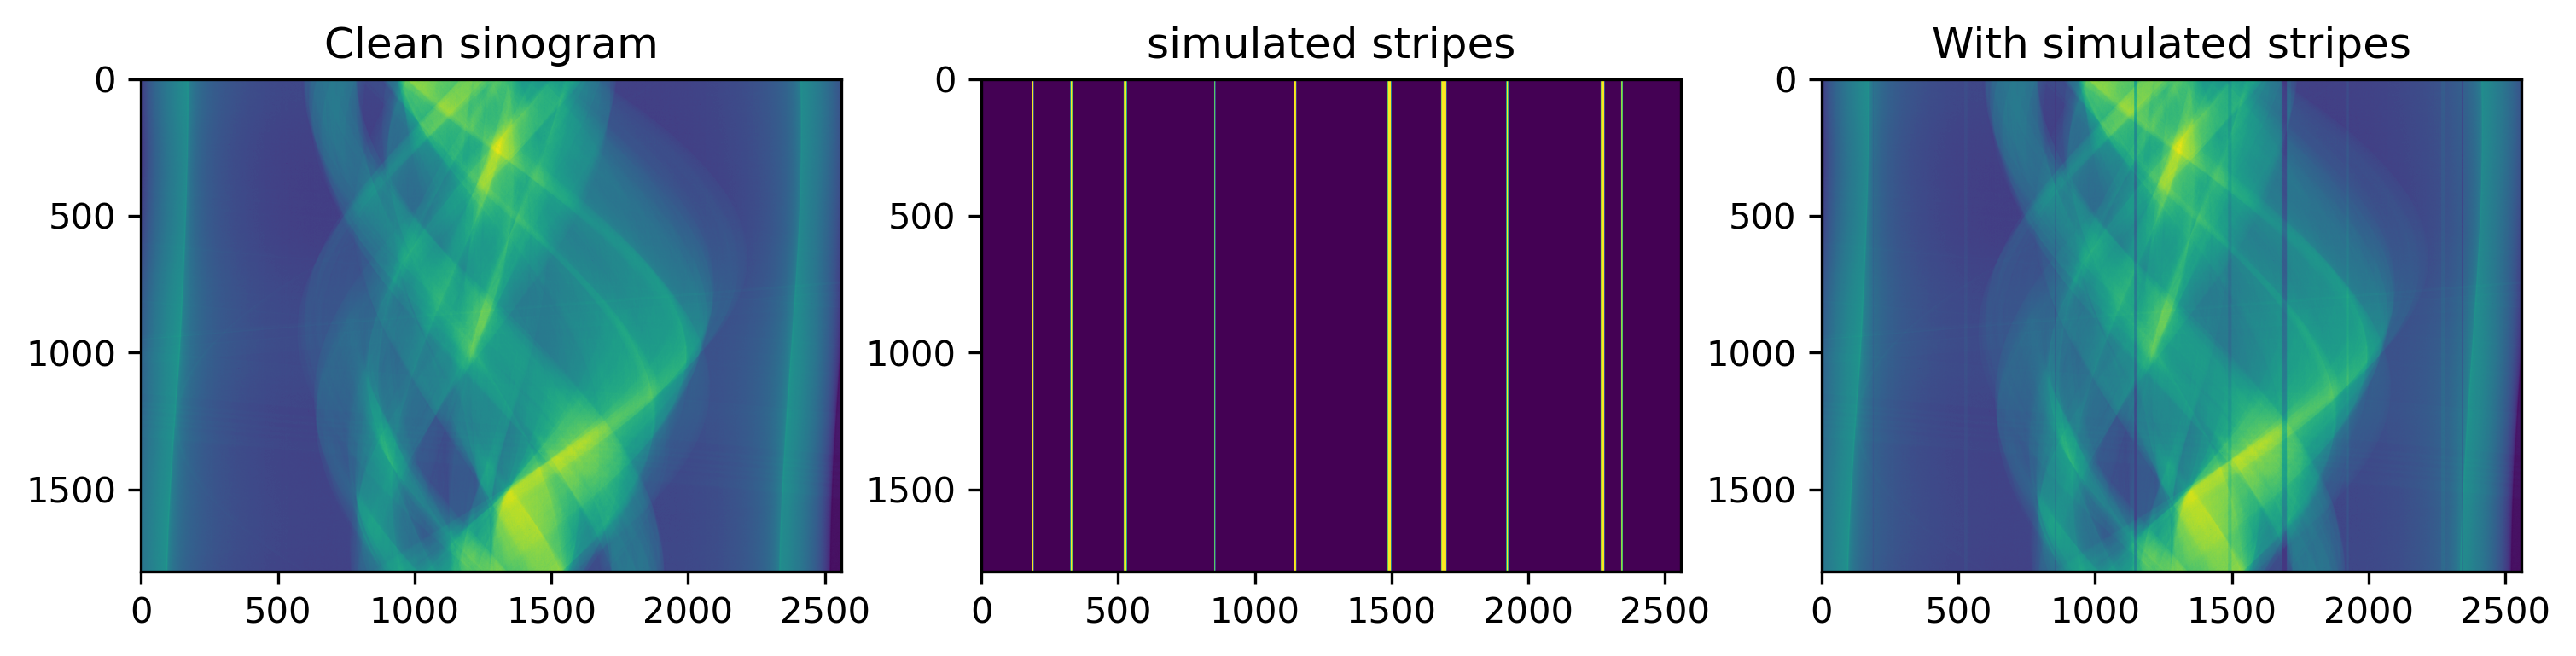

In [8]:
sliceSel = 200
plt.figure() 
plt.subplot(131)
plt.imshow(cleans[sliceSel,:,:],vmin=0, vmax=65535)
plt.title('Clean sinogram')
plt.subplot(132)
plt.imshow(mask[sliceSel,:,:])
plt.title('simulated stripes')
plt.subplot(133)
plt.imshow(stripes[sliceSel,:,:])
plt.title('With simulated stripes')
plt.show()

## Compare Results

### RMSE from Clean to Stripe (i.e. control)

In [9]:
# calculating RMSE for the stripes region ONLY
rmse_stripes = root_mean_squared_error(cleans[mask == True], stripes[mask == True])
print(f"{rmse_stripes=}")

rmse_stripes=4886.932


In [10]:
# calculating RMSE for the whole sinogram but not the stripes region
rmse_nostripes = root_mean_squared_error(cleans[mask == False], stripes[mask == False])
print(f"{rmse_nostripes=}")

rmse_nostripes=0.0


### RMSE of Fourier Wavelet

In [48]:
start_time = datetime.now()
fw = fourier_wavelet(stripes, level=None, wname='db5', sigma=0.6, pad=True, ncore=18)
print(f"Time: {datetime.now() - start_time}")
rmse_fw_stripes = root_mean_squared_error(cleans[mask == True], fw[mask == True])
rmse_fw_nostripes = root_mean_squared_error(cleans[mask == False], fw[mask == False])
print(f"{rmse_fw_stripes=}")
print(f"{rmse_fw_nostripes=}")

Time: 0:06:25.900328
rmse_fw_stripes=3013.018
rmse_fw_nostripes=2017.4911


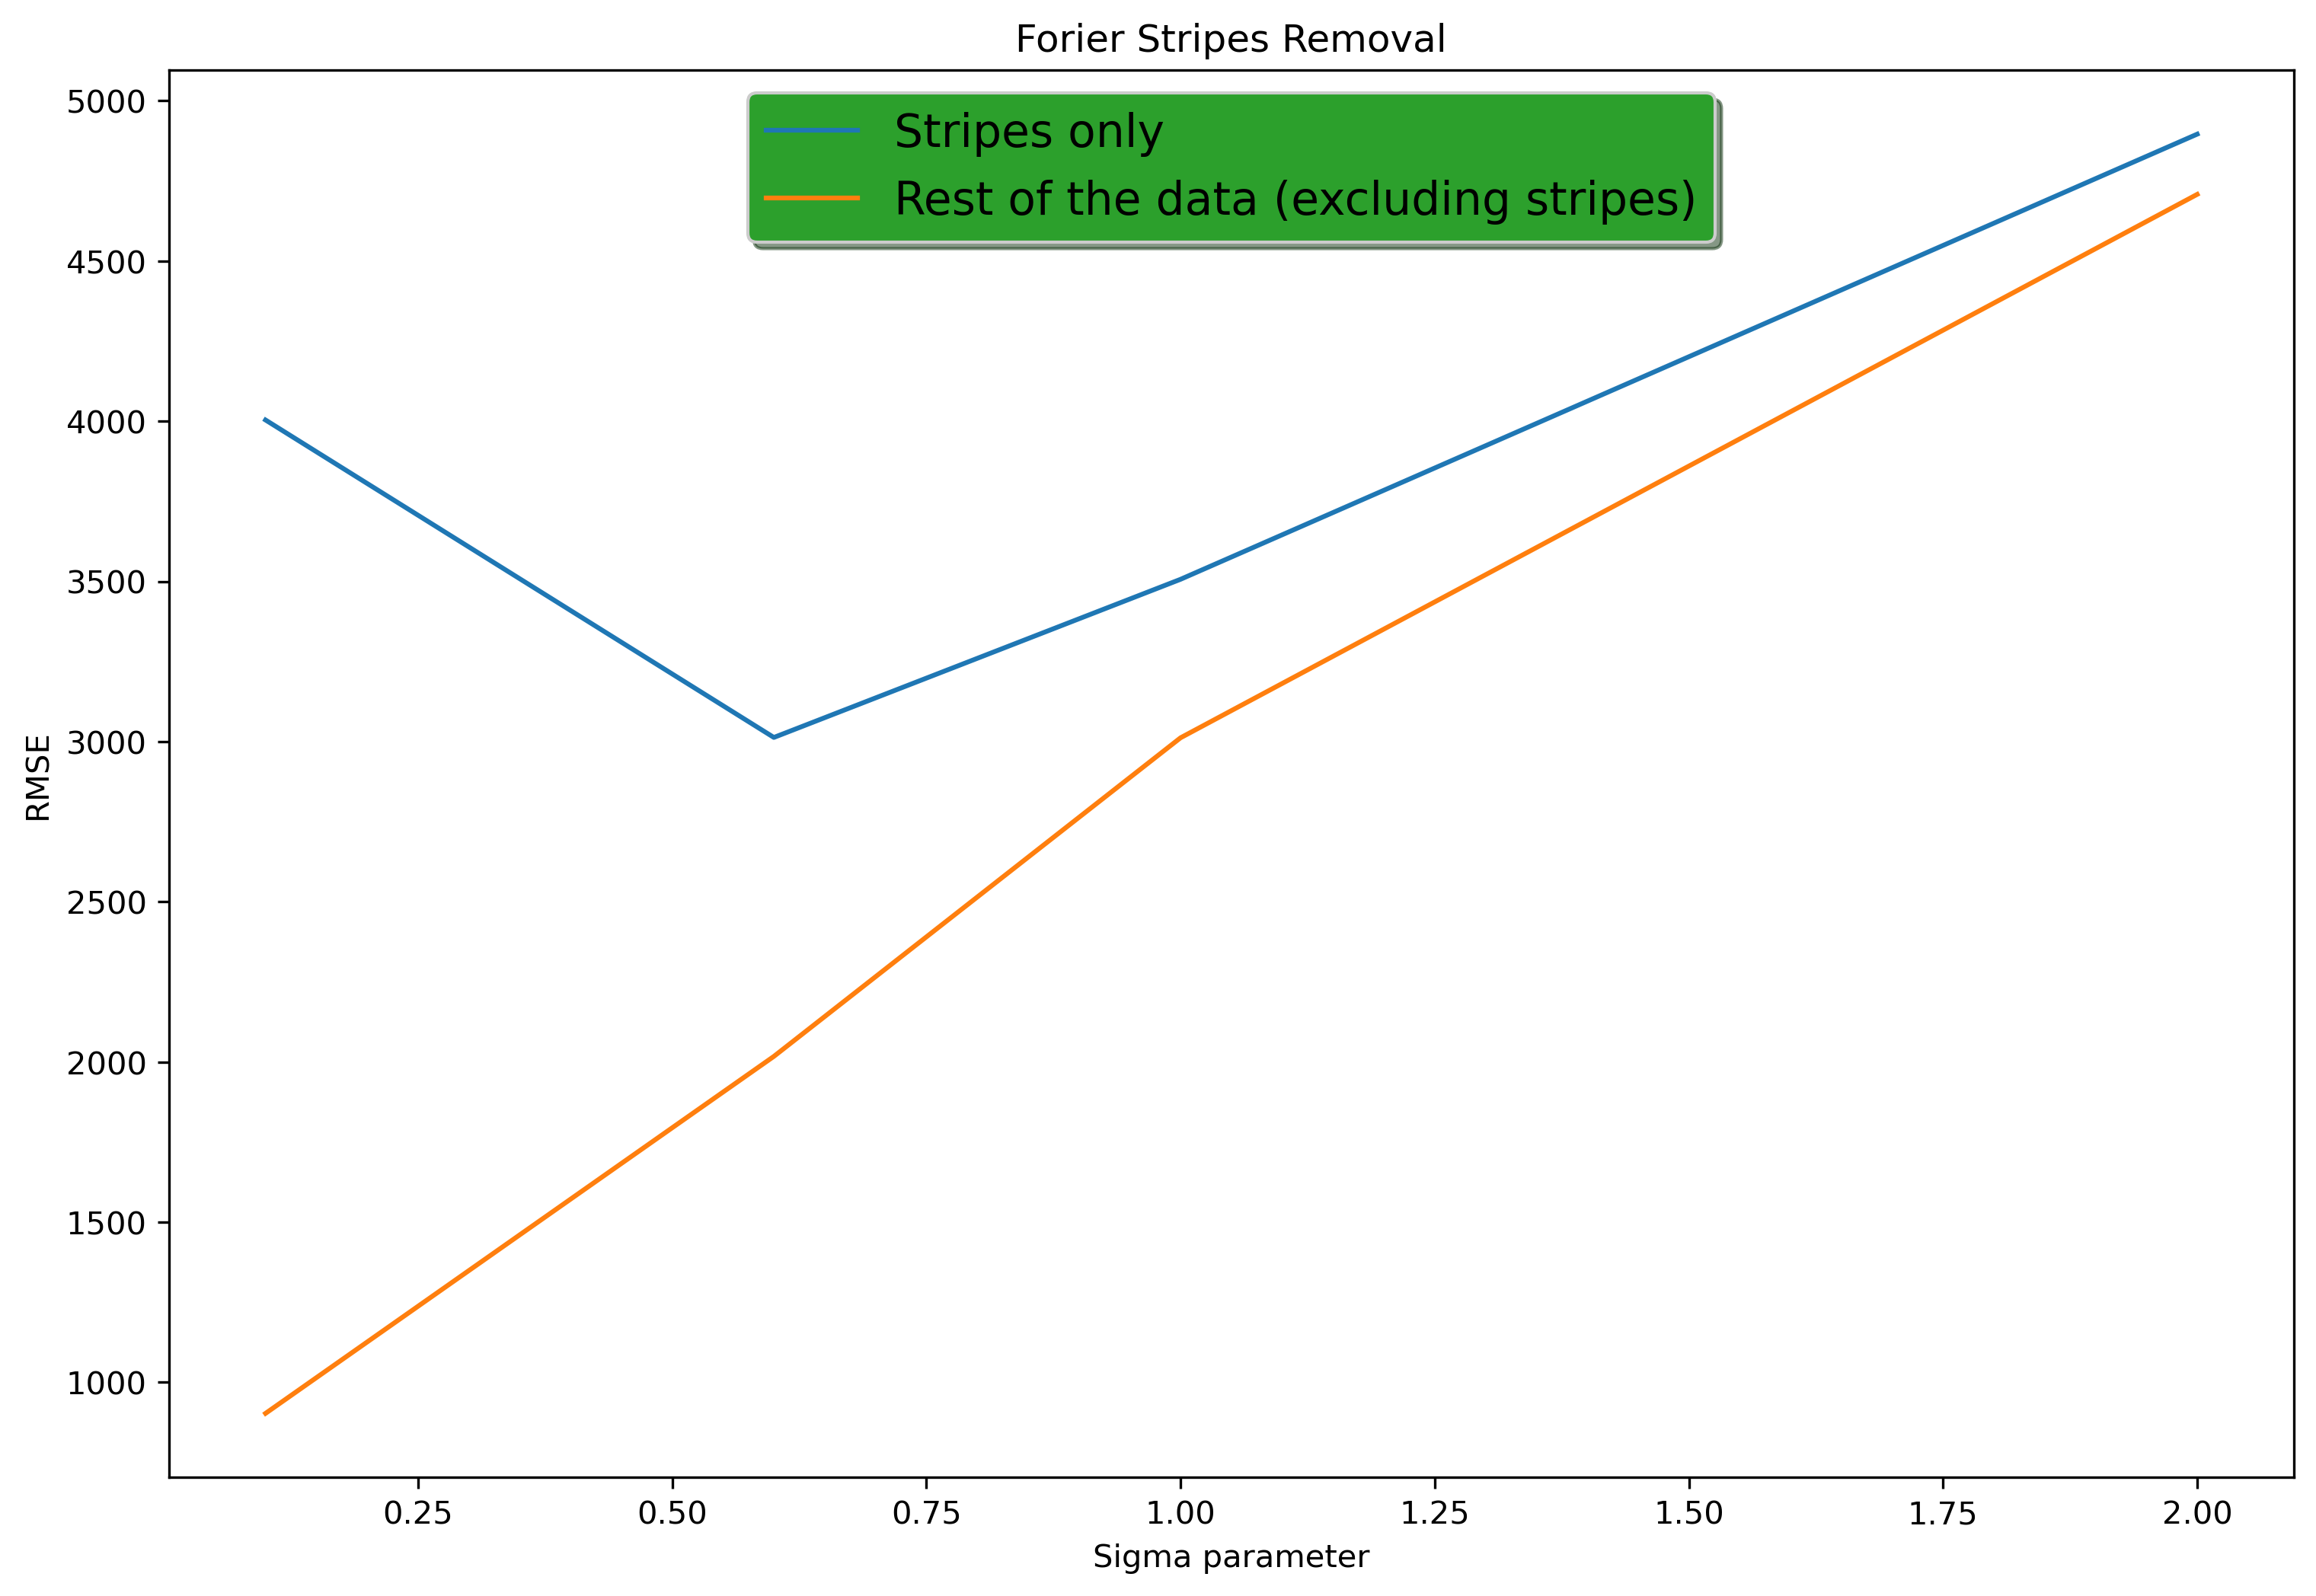

In [9]:
# optimisation for sigma, good value is around sigma=0.6
rmse_fw_stripes = np.array([4896.1074, 3506.6086, 3013.018, 4003.8914])
rmse_fw_nostripes = np.array([4708.1445, 3011.8882, 2017.4911, 903.21564])
sigma_par = np.array([2, 1, 0.6, 0.1])
###### plotting
fig, ax = plt.subplots()
ax.plot(sigma_par, rmse_fw_stripes, label='Stripes only')
ax.plot(sigma_par, rmse_fw_nostripes, label='Rest of the data (excluding stripes)')
ax.set_title('Forier Stripes Removal')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.xlabel("Sigma parameter")
plt.ylabel("RMSE")

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C2')
plt.show()

### RMSE of Nghia Vo's Sorting algorithm

In [18]:
start_time = datetime.now()
vo_sorting = remove_stripes_based_sorting(stripes, size=31, dim=1, ncore=16)
print(f"Time: {datetime.now() - start_time}")
rmse_vo_stripes = root_mean_squared_error(cleans[mask == True], vo_sorting[mask == True])
rmse_vo_nostripes = root_mean_squared_error(cleans[mask == False], vo_sorting[mask == False])
print(f"{rmse_vo_stripes=}")
print(f"{rmse_vo_nostripes=}")

Time: 0:24:57.287673
rmse_vo_stripes=3220.4485
rmse_vo_nostripes=206.97923


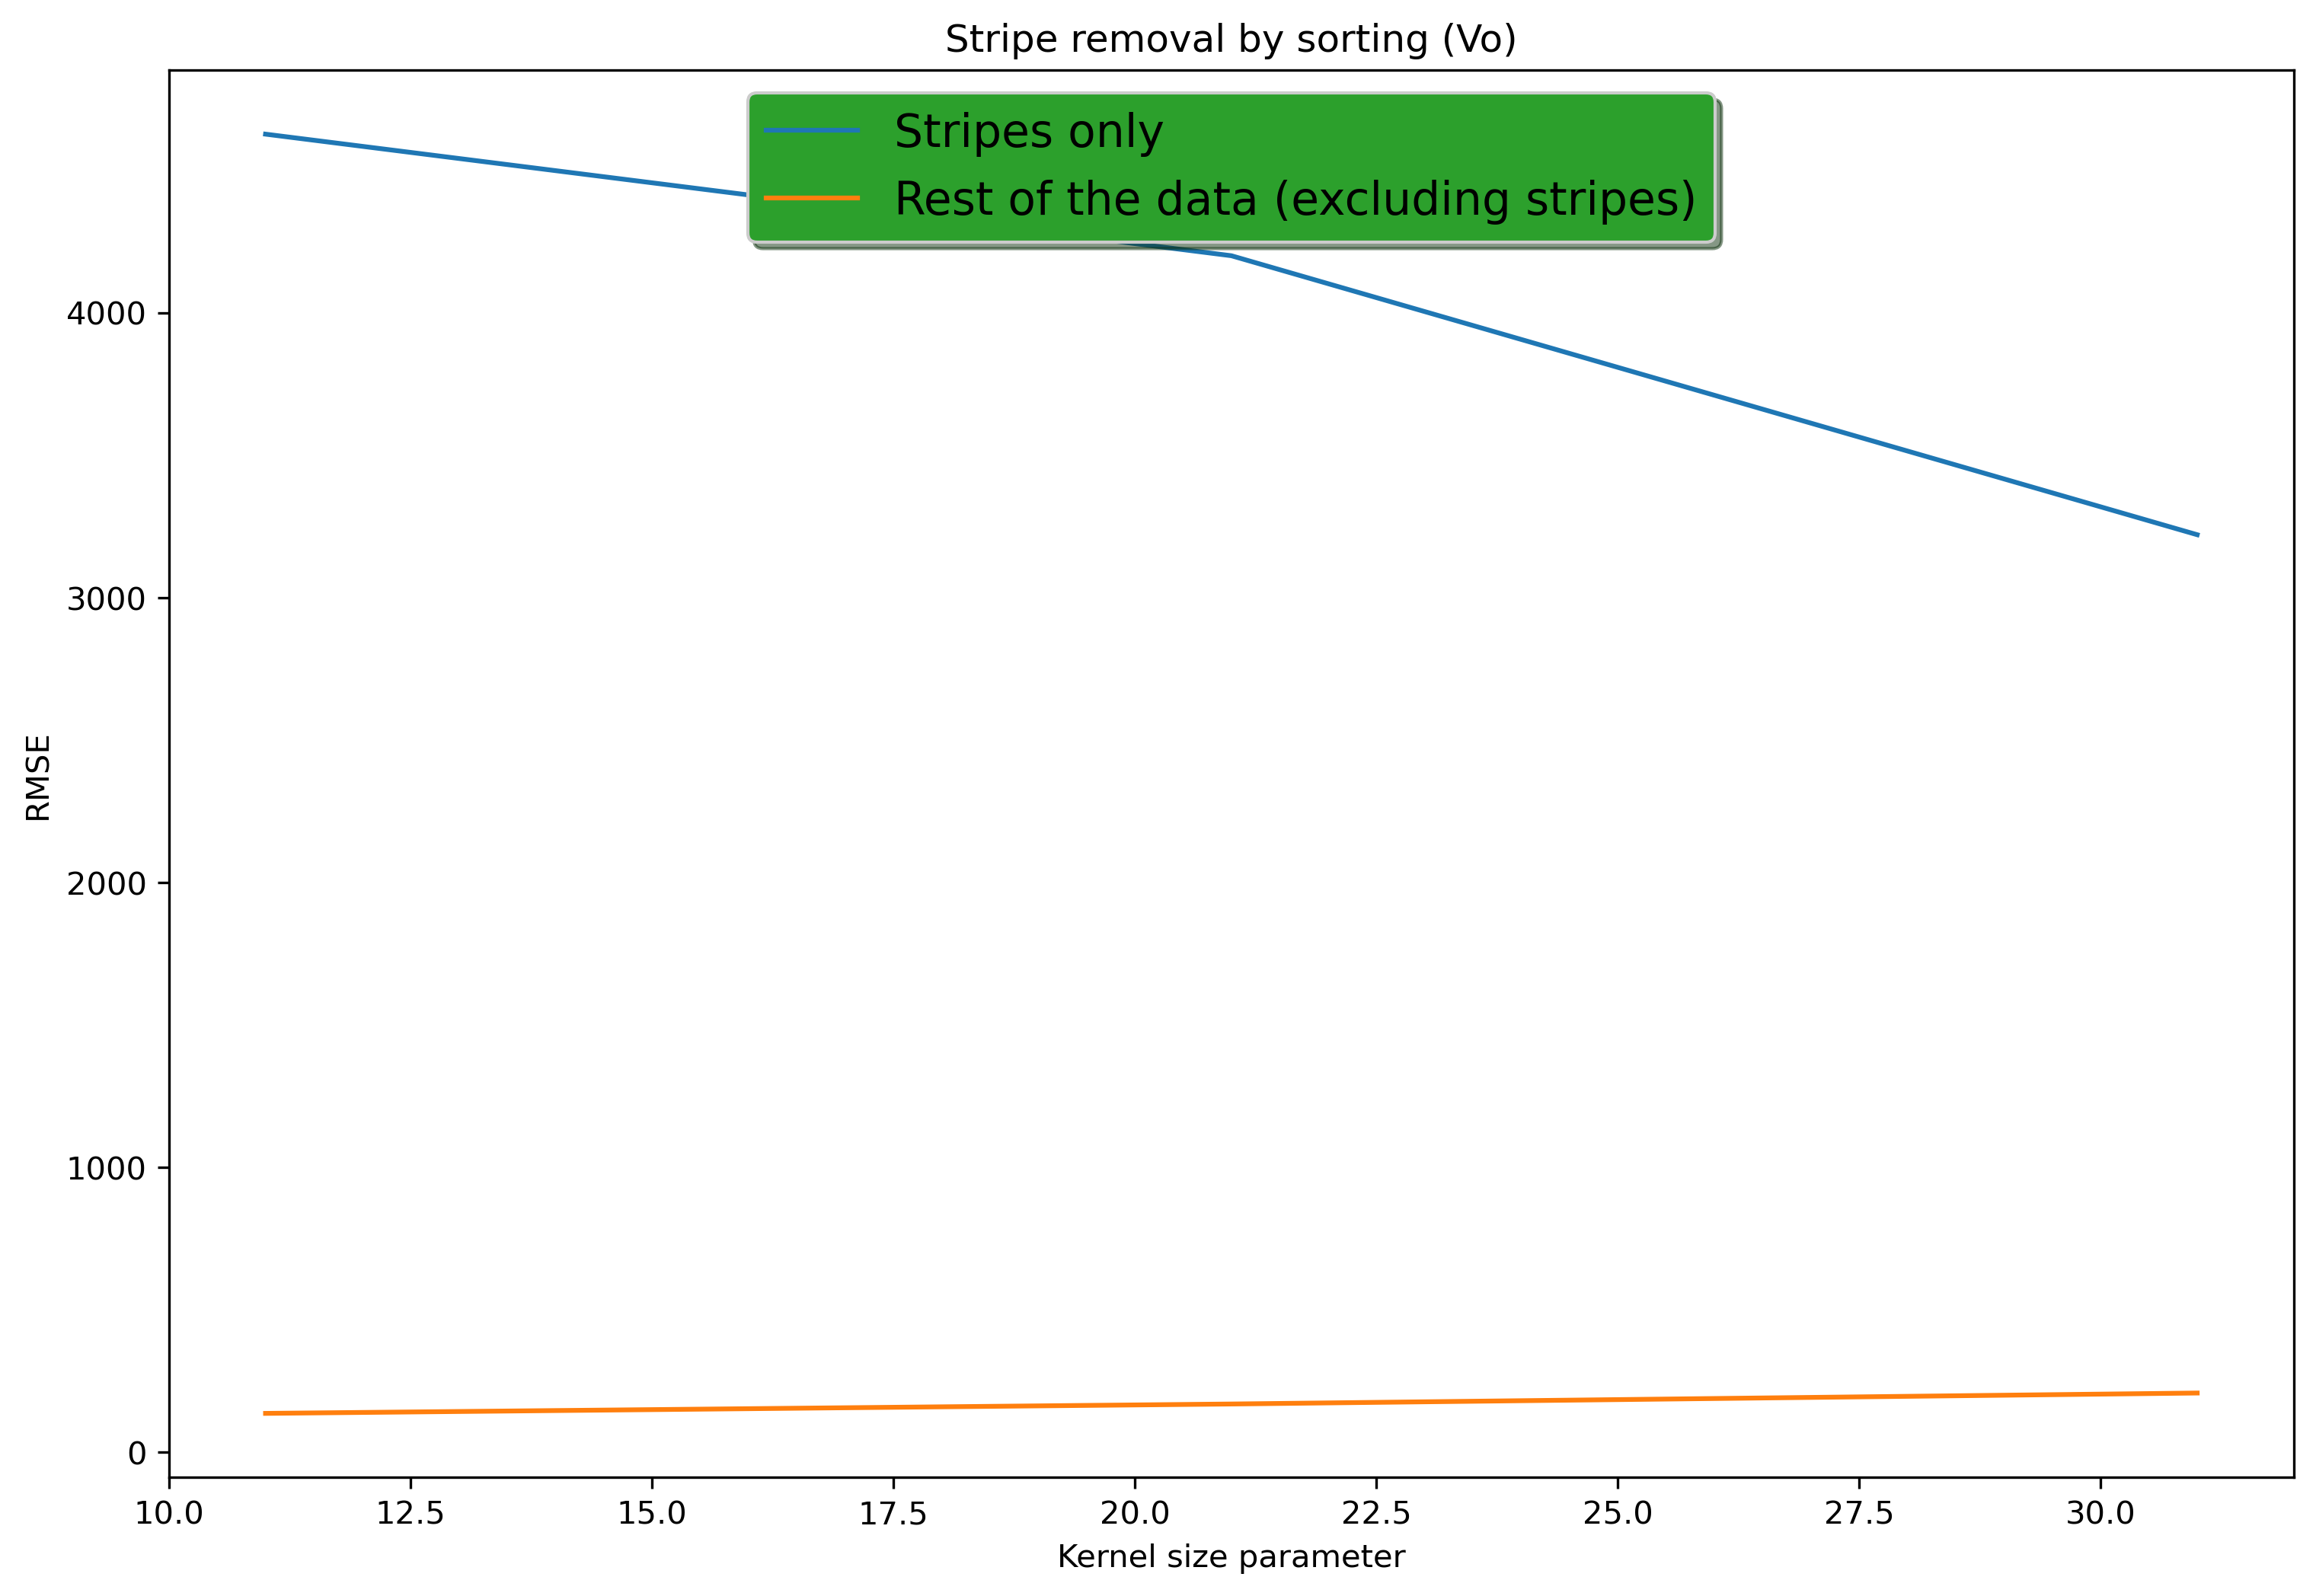

In [19]:
rmse_vo_stripes = np.array([4626.851, 4199.986, 3220.4485])
rmse_vo_nostripes = np.array([135.51591, 168.45128, 206.97923])
size_kernel = np.array([11, 21, 31])
###### plotting
fig, ax = plt.subplots()
ax.plot(size_kernel, rmse_vo_stripes, label='Stripes only')
ax.plot(size_kernel, rmse_vo_nostripes, label='Rest of the data (excluding stripes)')
ax.set_title('Stripe removal by sorting (Vo)')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.xlabel("Kernel size parameter")
plt.ylabel("RMSE")

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C2')
plt.show()

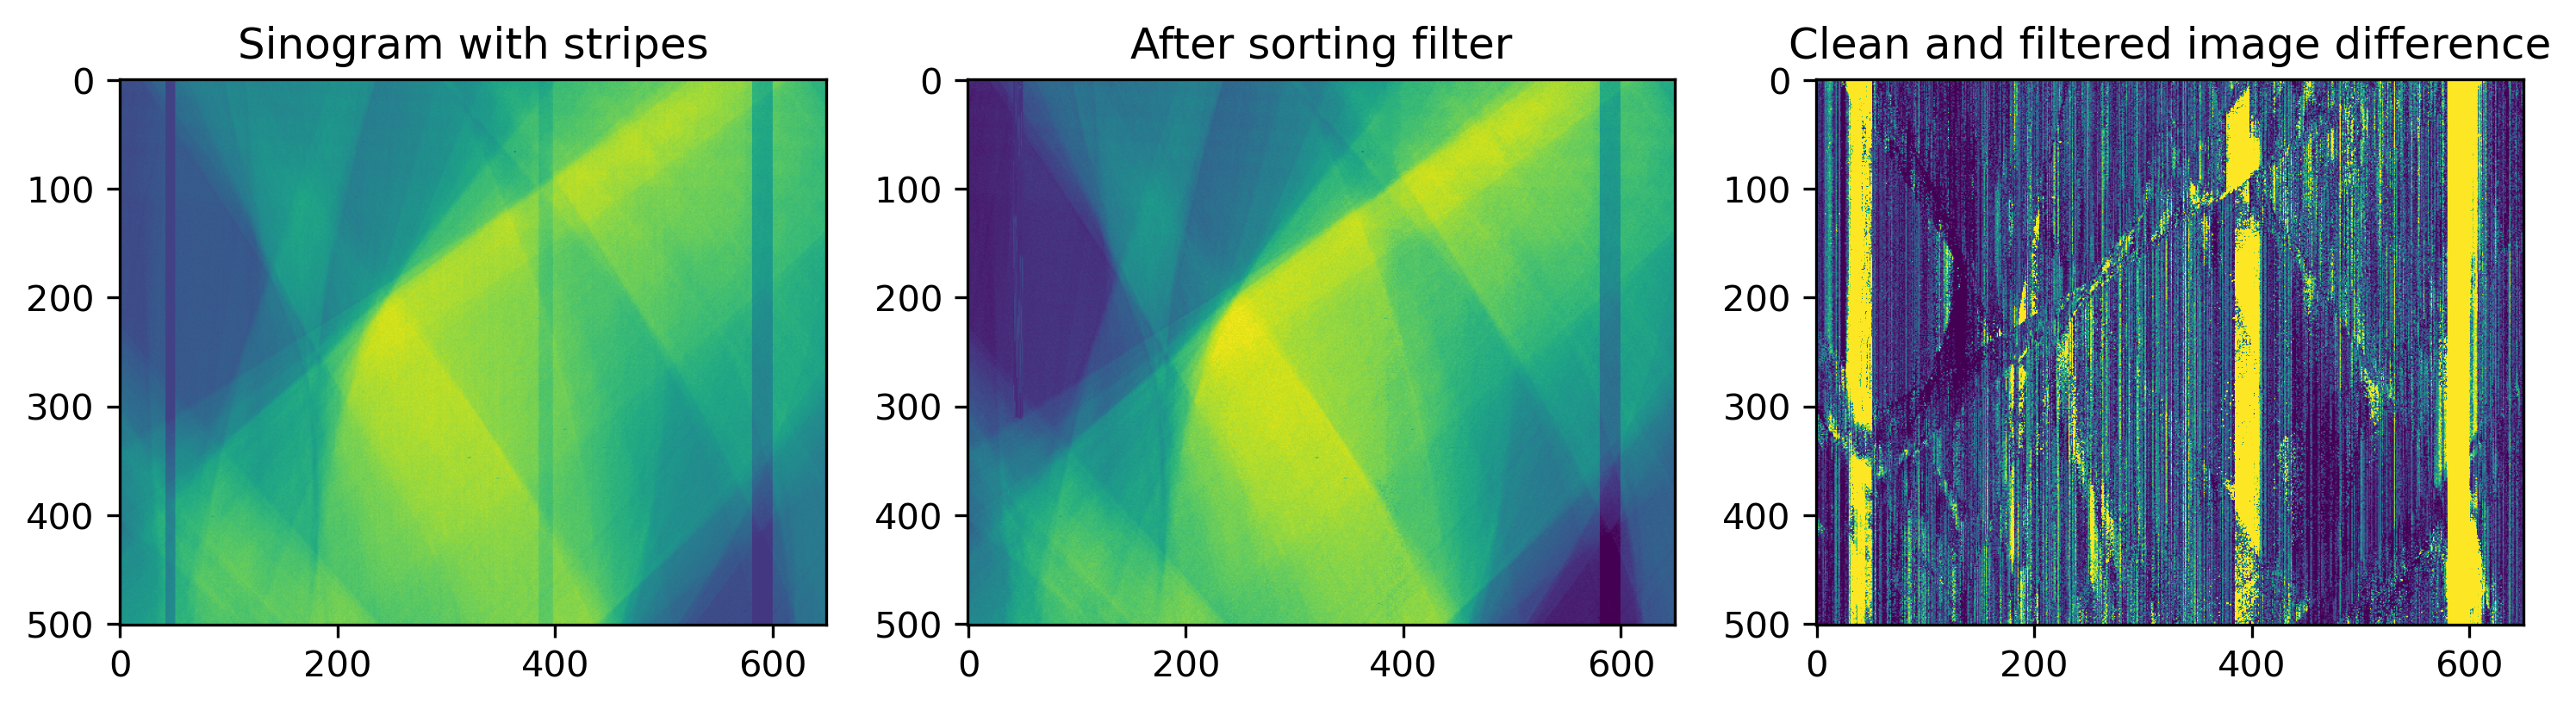

In [29]:
# we need to demonstrate the effect of stripes removal and also the removal of useful data
sliceSel = 200
plt.figure() 
plt.subplot(131)
plt.imshow(stripes[sliceSel,1300:1900, 1100:1750],vmin=0, vmax=65535)
plt.title('Sinogram with stripes')
plt.subplot(132)
plt.imshow(vo_sorting[sliceSel,1300:1900, 1100:1750])
plt.title('After sorting filter')
plt.subplot(133)
plt.imshow(np.abs(cleans[sliceSel,1300:1900, 1100:1750] - vo_sorting[sliceSel,1300:1900, 1100:1750]), vmin=0, vmax=600)
plt.title('Clean and filtered image difference')
plt.show()

### RMSE of Larix NDF Inpainting

In [16]:
start_time = datetime.now()
larix_ndf = remove_stripes_larix(stripes, mask, mode='NDF')
print(f"Time: {datetime.now() - start_time}")
rmse_lrx_ndf = root_mean_squared_error(cleans[mask == True], larix_ndf[mask == True])
print(f"{rmse_lrx_ndf=}")

Time: 3:12:20.429058
rmse_lrx_ndf=741.4547


In [ ]:
rmse_lrx_ndf = np.array([741.4547])

In [ ]:
sliceSel = 200
plt.figure() 
plt.subplot(121)
plt.imshow(stripes[sliceSel,1300:1900, 1100:1750],vmin=0, vmax=65535)
plt.title('Sinogram with stripes')
plt.subplot(122)
plt.imshow(larix_ndf[sliceSel,1300:1900, 1100:1750])
plt.title('Euclidian inpainting (Larix)')
plt.show()

In [18]:
### RMSE of Larix INPAINT_EUCL_WEIGHTED Inpainting
start_time = datetime.now()
larix_euclidian = remove_stripes_larix(stripes, mask, mode='EUCL')
print(f"Time: {datetime.now() - start_time}")
rmse_lrx_euc = root_mean_squared_error(cleans[mask == True], larix_euclidian[mask == True])
rmse_lrx_euc_nostripes = root_mean_squared_error(cleans[mask == False], larix_euclidian[mask == False])
print(f"{rmse_lrx_euc=}")
print(f"{rmse_lrx_euc_nostripes=}")

Time: 0:17:59.305808
rmse_lrx_euc=1150.7892
rmse_lrx_euc_nostripes=0.0


In [ ]:
rmse_lrx_euc = np.array([1102, 1150.2349, 1208.7281])
windowsize_half_vect = np.array([1, 2, 3])

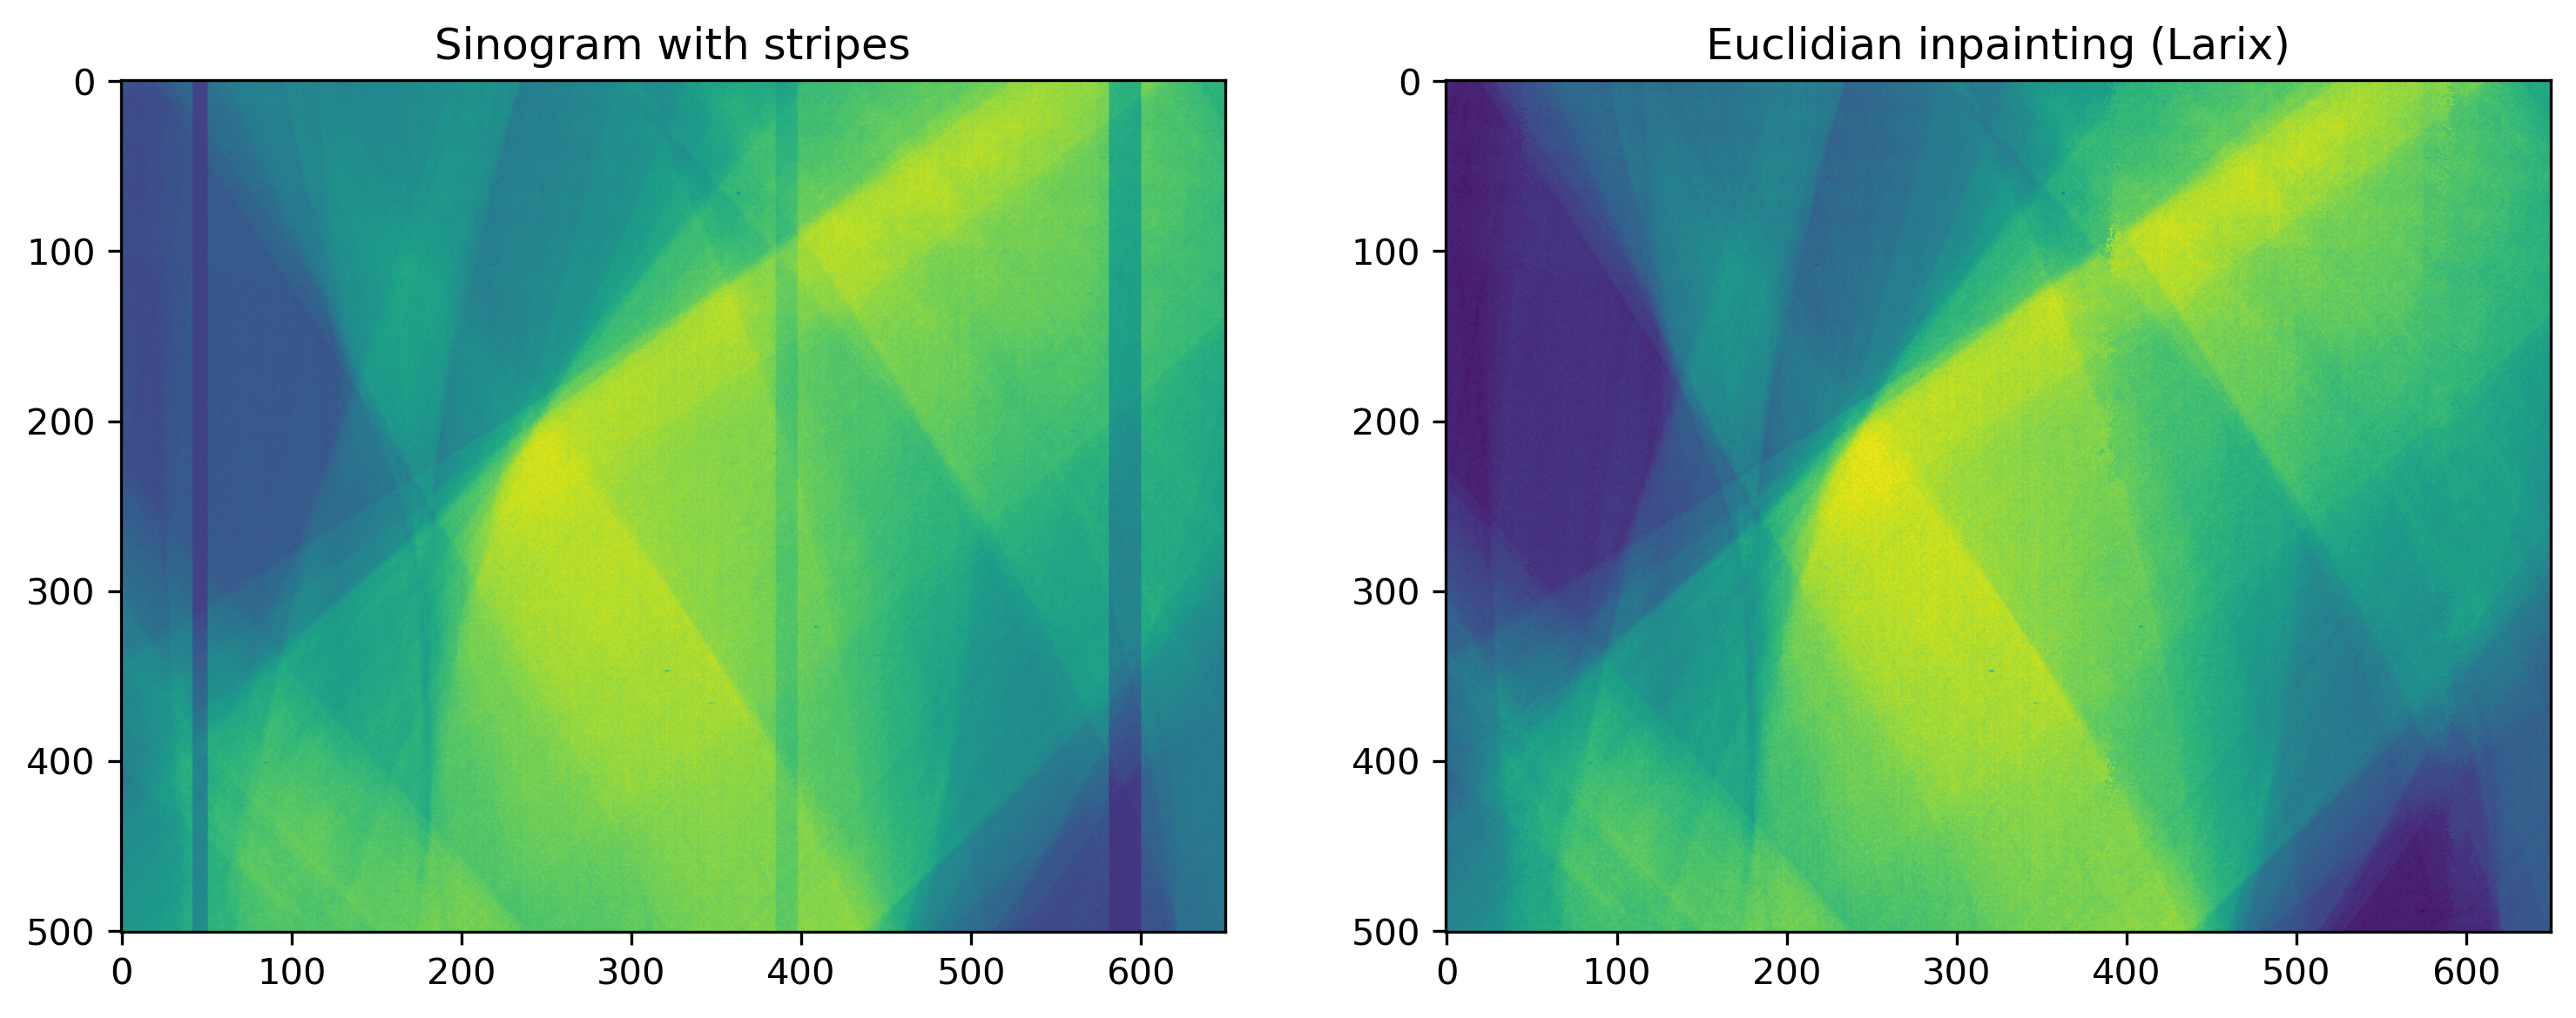

In [19]:
sliceSel = 200
plt.figure() 
plt.subplot(121)
plt.imshow(stripes[sliceSel,1300:1900, 1100:1750],vmin=0, vmax=65535)
plt.title('Sinogram with stripes')
plt.subplot(122)
plt.imshow(larix_euclidian[sliceSel,1300:1900, 1100:1750])
plt.title('Euclidian inpainting (Larix)')
plt.show()

### RMSE of NoStripesNet Inpainting
Running the model without a GPU can take ages (e.g. ~2 hours for the entire volume), so to save time only the plotting indexes are inpainted.

In [ ]:
start_time = datetime.now()
nsn = np.empty_like(cleans)
for i, idx in enumerate(idxs):
    nsn[idx] = v.get_model_sinogram(v.clean_idxs[idx], 'fake').astype(np.float32)
print(f"Time: {datetime.now() - start_time}")
rmse_nsn = root_mean_squared_error(cleans[idxs], nsn[idxs])
print(f"{rmse_nsn=}")

## Visualize Results

In [12]:
sino_idxs = [415, 605, 804]
idxs = [v.clean_idxs.index(i) for i in idxs]

NameError: name 'idxs' is not defined

### Control

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Clean {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(cleans[idxs[0]], cmap='gray')
axs[0, 1].set_title(f"Clean {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(cleans[idxs[1]], cmap='gray')
axs[0, 2].set_title(f"Clean {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(cleans[idxs[2]], cmap='gray')

axs[1, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(stripes[idxs[0]], cmap='gray')
axs[1, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(stripes[idxs[1]], cmap='gray')
axs[1, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(stripes[idxs[2]], cmap='gray')

In [ ]:
clean_recons = [
    reconstruct(cleans[idxs[0]], ncore=ncore),
    reconstruct(cleans[idxs[1]], ncore=ncore),
    reconstruct(cleans[idxs[2]], ncore=ncore),
]
stripe_recons = [
    reconstruct(stripes[idxs[0]], ncore=ncore),
    reconstruct(stripes[idxs[1]], ncore=ncore),
    reconstruct(stripes[idxs[2]], ncore=ncore),
]

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Clean {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(clean_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 1].set_title(f"Clean {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(clean_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 2].set_title(f"Clean {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(clean_recons[2], cmap='gray', vmin=-0.02, vmax=0.14)

axs[1, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(stripe_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(stripe_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(stripe_recons[2], cmap='gray', vmin=-0.01, vmax=0.07)

### Fourier Wavelet

In [ ]:
fw_recons = [
    reconstruct(fw[idxs[0]], ncore=16),
    reconstruct(fw[idxs[1]], ncore=16),
    reconstruct(fw[idxs[2]], ncore=16),
]

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripes[idxs[0]], cmap='gray')
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripes[idxs[1]], cmap='gray')
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripes[idxs[2]], cmap='gray')

axs[1, 0].set_title(f"FW {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(fw[idxs[0]], cmap='gray')
axs[1, 1].set_title(f"FW {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(fw[idxs[1]], cmap='gray')
axs[1, 2].set_title(f"FW {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(fw[idxs[2]], cmap='gray')

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripe_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripe_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripe_recons[2], cmap='gray', vmin=-0.01, vmax=0.07)

axs[1, 0].set_title(f"FW {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(fw_recons[0], cmap='gray', vmin=-0.01, vmax=0.14)
axs[1, 1].set_title(f"FW {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(fw_recons[1], cmap='gray', vmin=-0.01, vmax=0.14)
axs[1, 2].set_title(f"FW {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(fw_recons[2], cmap='gray', vmin=-0.01, vmax=0.14)

### Nghia Vo's algorithm

In [ ]:
vo_recons = [
    reconstruct(vo[idxs[0]], ncore=16),
    reconstruct(vo[idxs[1]], ncore=16),
    reconstruct(vo[idxs[2]], ncore=16),
]

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripes[idxs[0]], cmap='gray')
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripes[idxs[1]], cmap='gray')
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripes[idxs[2]], cmap='gray')

axs[1, 0].set_title(f"Vo {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(vo[idxs[0]], cmap='gray')
axs[1, 1].set_title(f"Vo {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(vo[idxs[1]], cmap='gray')
axs[1, 2].set_title(f"Vo {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(vo[idxs[2]], cmap='gray')

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripe_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripe_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripe_recons[2], cmap='gray', vmin=-0.01, vmax=0.07)

axs[1, 0].set_title(f"Vo {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(vo_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 1].set_title(f"Vo {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(vo_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 2].set_title(f"Vo {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(vo_recons[2], cmap='gray', vmin=-0.02, vmax=0.14)

### Larix NDF Inpainting

In [ ]:
larix_recons = [
    reconstruct(larix[idxs[0]], ncore=16),
    reconstruct(larix[idxs[1]], ncore=16),
    reconstruct(larix[idxs[2]], ncore=16),
]

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripes[idxs[0]], cmap='gray')
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripes[idxs[1]], cmap='gray')
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripes[idxs[2]], cmap='gray')

axs[1, 0].set_title(f"Larix {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(larix[idxs[0]], cmap='gray')
axs[1, 1].set_title(f"Larix {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(larix[idxs[1]], cmap='gray')
axs[1, 2].set_title(f"Larix {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(larix[idxs[2]], cmap='gray')

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripe_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripe_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripe_recons[2], cmap='gray', vmin=-0.01, vmax=0.07)

axs[1, 0].set_title(f"Larix {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(larix_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 1].set_title(f"Larix {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(larix_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 2].set_title(f"Larix {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(larix_recons[2], cmap='gray', vmin=-0.02, vmax=0.14)

### NoStripesNet Inpainting

In [ ]:
nsn_recons = [
    reconstruct(nsn[idxs[0]], ncore=16),
    reconstruct(nsn[idxs[1]], ncore=16),
    reconstruct(nsn[idxs[2]], ncore=16),
]

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripes[idxs[0]], cmap='gray')
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripes[idxs[1]], cmap='gray')
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripes[idxs[2]], cmap='gray')

axs[1, 0].set_title(f"NSN {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(nsn[idxs[0]], cmap='gray')
axs[1, 1].set_title(f"NSN {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(nsn[idxs[1]], cmap='gray')
axs[1, 2].set_title(f"NSN {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(nsn[idxs[2]], cmap='gray')

In [ ]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].set_title(f"Stripe {sino_idxs[0]}")
axs[0, 0].axis('off')
axs[0, 0].imshow(stripe_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 1].set_title(f"Stripe {sino_idxs[1]}")
axs[0, 1].axis('off')
axs[0, 1].imshow(stripe_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[0, 2].set_title(f"Stripe {sino_idxs[2]}")
axs[0, 2].axis('off')
axs[0, 2].imshow(stripe_recons[2], cmap='gray', vmin=-0.01, vmax=0.07)

axs[1, 0].set_title(f"NSN {sino_idxs[0]}")
axs[1, 0].axis('off')
axs[1, 0].imshow(nsn_recons[0], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 1].set_title(f"NSN {sino_idxs[1]}")
axs[1, 1].axis('off')
axs[1, 1].imshow(nsn_recons[1], cmap='gray', vmin=-0.02, vmax=0.14)
axs[1, 2].set_title(f"NSN {sino_idxs[2]}")
axs[1, 2].axis('off')
axs[1, 2].imshow(nsn_recons[2], cmap='gray', vmin=-0.02, vmax=0.14)